In [288]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

# Paper recap

x1 and x2 are sequences generated from constrained random walks.  x1 (x2) changes with a prob per unit time of 
0.65 (0.99) by a random amount uniformly distributed between -0.5 and 0.5 (-1 and 1). The modulus of x is then 
taken to ensure a positive sequence. Initial v are randomly selected from a unif fistrbution between -1 and 1. 

v1 ans v2 are unif randomly selected between -1 and +1.

100 temporal patterns are simulated numerically with different sequences for x1 and x2, and different inital v1 and v2. Tau goes from 0.5 to 0.8 with dt=0.1

Network: 8 hidden nodes and trained on 50 of the processes. Results shown on 50 of the processes not seen during the training. Set alpha=0.01 and beta=40 000. 

Temporak pattern: network produces sequence v(1) ... v(T) given initial conditions v(0) and ext input x(0), ..., x(T-1) and time steps. 

The neural network takes as input v(i) and x(i), and computes the function dv/dt=F(v,x).
First layer: inputs v(i) and x(i)
Second layer: 8 hidden nodes with tanh function 
Output layr: dv/dt no activation function 

# Generate the data 

### The diff equation

In [289]:
def diff_equ(t, V, x1, x2):
    #x1, x2 =tf.split(X[tf.cast(t, tf.int32)],1)
    v1, v2 = V 
    dv1= x1[tf.dtypes.cast(tf.round(t), tf.int32)] -2*v1 + 8*v2 -x1[tf.dtypes.cast(tf.round(t), tf.int32)]*v1
    dv2= x2[tf.dtypes.cast(tf.round(t), tf.int32)] -5*v1 + v2 -x2[tf.dtypes.cast(tf.round(t), tf.int32)]*v2
    dV=np.array([dv1, dv2])
    return dV   


### Generate x value sequences for 0... T-1

In [290]:
def gen_x(T):
    #initial values 
    x1=np.absolute(np.array([np.random.uniform(low=-0.5, high=0.5)]))
    x2=np.absolute(np.array([np.random.uniform(low=-1.0, high=1.0)]))
    #x1=np.absolute(np.array([[np.random.uniform(low=-0.5, high=0.5)]]))
    #x2=np.absolute(np.array([[np.random.uniform(low=-1.0, high=1.0)]]))
    for i in range(T): 
        #generate a bernouilli according to PD
        p1 = np.random.binomial(1,p=0.65)
        p2 = np.random.binomial(1,p=0.99)
        u1=np.absolute(np.array([np.random.uniform(low=-0.5, high=0.5)]))
        u2=np.absolute(np.array([np.random.uniform(low=-1.0, high=1.0)]))
        x1=np.append(x1, x1[-1]+p1*u1, axis=0)
        x2=np.append(x2, x2[-1]+p2*u2, axis=0)
    #X=np.hstack((x1,x2))
    return x1, x2

In [291]:
#Regularisation para see equ.(24)
alpha=0.01
#Loss function para´see equ.(10)
beta=40000

ODESolver = tfp.math.ode.DormandPrince()

# initial conditions and time grid
t_initial = 0 # initial time
t_final = 8 # final time
n_times = 80 # number of time steps to churn out solution for
times = np.linspace(t_initial, t_final, n_times).astype(np.float32) 

#v1=np.array([[np.random.uniform(low=-1.0, high=1.0)]])
#v2=np.array([[np.random.uniform(low=-1.0, high=1.0)]])
#v_initial = np.array([v1, v2]).astype(np.float32) # initial state vector

v1=np.random.uniform(low=-1.0, high=1.0)
v2=np.random.uniform(low=-1.0, high=1.0)

v_initial = np.array([v1, v2]).astype(np.float32)

x1, x2=gen_x(n_times)
# integrate the ODE
results = ODESolver.solve(diff_equ, # system of ODEs (gradient function)
                                   t_initial, # initial time
                                   v_initial, # initial state
                                   solution_times=times,
                                   constants={'x1': x1.astype(np.float32),'x2': x2.astype(np.float32)}) # time grid to spit out solutions for

# extract results for the state solutions v(t)
data = tf.cast(tf.stack(results.states, axis=-1), tf.float32)

In [292]:
v_initial

array([ 0.04835411, -0.6405342 ], dtype=float32)

In [293]:
dt=0.1
def euler(v, dv):
    dv1, dv2=dv
    new_v1=v1+dv1*dt
    new_v2=v2+dv2*dt
    V=tf.stack([new_v1, new_v2])
    return V

In [294]:
# weights and biases:
n_state = 2
n_ext=2
n_hidden = 8
W1_v = tf.Variable(tf.random.normal([(n_state), n_hidden], 0, 0.1),  trainable=True)
W1_x=  tf.Variable(tf.random.normal([(n_ext), n_hidden], 0, 0.1),  trainable=True)
b1 = tf.Variable(tf.random.normal([n_hidden], 0, 0.1),  trainable=True)
W2 = tf.Variable(tf.random.normal([n_hidden, n_state], 0, 0.1),  trainable=True)
b2 = tf.Variable(tf.random.normal([n_state], 0, 0.1),  trainable=True)

def dvdt_nn(t,v,x):
    output=tf.matmul(tf.expand_dims(v, axis=0), W1_v)+tf.matmul(tf.expand_dims(x, axis=0), W1_x)+ b1
    dvdt = tf.matmul(tf.math.tanh(output), W2) + b2   
    return tf.squeeze(dvdt, axis=0)

For a given epoch: 
    Error: e=v-T where T is the target 
    Total error: 1/2 \sum \beta(e)^2

### BJ step 

In [295]:
x=np.array([x1,x2]).astype(np.float32)
x=np.transpose(x)

dvdt_nn(0, v_initial, x[0])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.0306344 , 0.15084189], dtype=float32)>

In [296]:

predictions

array([[0.6599839 , 0.4241022 ],
       [0.6570614 , 0.42263138],
       [0.6545524 , 0.42119375],
       [0.6534703 , 0.42052692],
       [0.6512192 , 0.41888776],
       [0.65092736, 0.41809377],
       [0.6496218 , 0.4174395 ],
       [0.64859146, 0.41655445],
       [0.64670265, 0.41532183],
       [0.6466064 , 0.41527537],
       [0.64531493, 0.41466442],
       [0.6432799 , 0.41371065],
       [0.6421506 , 0.4131909 ],
       [0.641802  , 0.4126795 ],
       [0.6407539 , 0.41201898],
       [0.64037704, 0.41183418],
       [0.6408523 , 0.41165274],
       [0.6401087 , 0.41131696],
       [0.64009535, 0.4113115 ],
       [0.640496  , 0.41120204],
       [0.64051116, 0.4110791 ],
       [0.63995975, 0.4108433 ],
       [0.6393891 , 0.41059983],
       [0.6390486 , 0.41039857],
       [0.638342  , 0.41009718],
       [0.63836515, 0.40982828],
       [0.63854074, 0.4096697 ],
       [0.6378877 , 0.4091116 ],
       [0.6378624 , 0.40881482],
       [0.637594  , 0.4085532 ],
       [0.

In [416]:
# choose optimizer
optimizer = tf.keras.optimizers.Adam(lr = 1)

# training step: computes predictions, compute MSE between predictions and data, computes gradients and applies them to the parameters
def training_step():
    
    # start the gradient tape: this records all operations in a way that gradients can be taken
    with tf.GradientTape() as tape:
        tape.watch([W1_v, W1_x, W2, b1, b2])
        predictions=[]
        traj=[]
        pred_v = v_initial
        for i in range(len(times)):
            net=dvdt_nn(times[i], pred_v, x[i])
            pred_v = euler(pred_v, net)
            predictions.append(pred_v)
        predictions=tf.stack(predictions)
        
        # calculate loss
        #loss=tf.reduce_mean(tf.square(error))     

        error=data-tf.transpose(predictions) 
        loss=tf.reduce_sum(tf.square(error)) 

    # calculate gradients
    gradients = tape.gradient(loss, tape.watched_variables())
    
    # make gradient step
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))   
    
    return loss

In [417]:
# list to keep the loss values for plotting later (to see if it's converged)
losses = []

# number of trainine epochs
n_epochs = 100

# progressbar
pbar = tqdm.tqdm_notebook(total = n_epochs, desc = "Optimizing")
pbar.set_postfix(ordered_dict={"loss":None}, refresh=True)

# train it! loop over epochs, doing a gradient update each step
for i in range(n_epochs):
    
    loss = training_step()
    losses.append(loss.numpy())
    
    # update progressbar
    pbar.update()
    pbar.set_postfix(ordered_dict={"loss":loss.numpy()}, refresh=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


HBox(children=(FloatProgress(value=0.0, description='Optimizing', style=ProgressStyle(description_width='initial')), HTML(value='')))

In [418]:
#data

In [419]:
#predictions

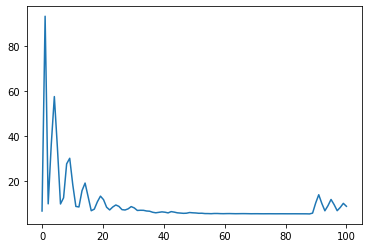

In [420]:
plt.plot(np.linspace(0, n_epochs, n_epochs), losses)


In [421]:
dataT=tf.transpose(data)
dataT[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.04835411, -0.6405342 ], dtype=float32)>

In [422]:
trajectories=np.asarray(predictions)
trajT=np.transpose(trajectories)
trajT

array([[0.6599839 , 0.6570614 , 0.6545524 , 0.6534703 , 0.6512192 ,
        0.65092736, 0.6496218 , 0.64859146, 0.64670265, 0.6466064 ,
        0.64531493, 0.6432799 , 0.6421506 , 0.641802  , 0.6407539 ,
        0.64037704, 0.6408523 , 0.6401087 , 0.64009535, 0.640496  ,
        0.64051116, 0.63995975, 0.6393891 , 0.6390486 , 0.638342  ,
        0.63836515, 0.63854074, 0.6378877 , 0.6378624 , 0.637594  ,
        0.6368435 , 0.63672286, 0.6360886 , 0.63562876, 0.63503116,
        0.6349326 , 0.6345804 , 0.6344813 , 0.63422024, 0.6338378 ,
        0.63347584, 0.63329077, 0.63301075, 0.6328676 , 0.6326614 ,
        0.63231474, 0.6319662 , 0.6317947 , 0.63146484, 0.63140535,
        0.63110894, 0.63100064, 0.6308642 , 0.6306867 , 0.63049114,
        0.6302915 , 0.63021016, 0.6300716 , 0.6298903 , 0.6297827 ,
        0.6297434 , 0.6296058 , 0.62943   , 0.62926424, 0.62914014,
        0.62902063, 0.62886846, 0.628818  , 0.6287087 , 0.6286461 ,
        0.62852675, 0.62845707, 0.62839586, 0.62

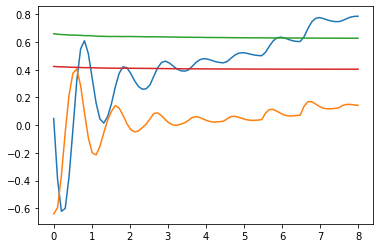

In [423]:
v_pred_x=trajT[0]
v_pred_y=trajT[1]

v_x=dataT[0]
v_y=dataT[1]

plt.plot(times, data[0])
plt.plot(times, data[1])
plt.plot(times, trajT[0])
plt.plot(times, trajT[1])

